# Table of Contents
1. [Data Wrangling](#Data_wrangling)<br>
    1a. [Dataframe cleaning](#cleaning)<br>
    1b. [Text preprocessing](#text)<br>

2. [EDA](#EDA)<br>
    2a. [Time Dependency](#Time)<br>
    2b. [Funding Goal](#Goal)<br>
    2c. [Text](#Text)<br>
    
3. [Machine Learning](#learn)<br>
    3a. [Logistic Regression](#logistic)<br>
    3b. [Deep Learning](#deep)
  
4. [Future Work](#future)

<a id='Data_wrangling'></a>

# 1. Data Wrangling
The datasets were found on webrobots.io where they crawl all Kickstarter projects once a month. For this project, the 2019-08-15 dataset was used with 56 datasets.
<br>
The data wrangling portion of this project is straightford. First we would have to eliminate features that are unrelated to campaign outcome. Also we like to create new features related to year and month to understand any temporal effect on pledge money. Then we would process the summary of campaign

In [1]:
import numpy as np
import pandas as pd
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import ngrams
from langdetect import detect
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Activation, Concatenate
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#define path and set up to import csv files
path = 'Dataset'
all_files = glob.glob(path +"/*.csv")

In [3]:
#create dataframes from all csv files
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col = None)
    li.append(df)
df = pd.concat(li, ignore_index = True)

In [4]:
#merge files
df = pd.concat(li, ignore_index = True)
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,103,"Funding the mixing, mastering, and promotion o...","{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",5612,US,1456593666,"{""id"":1531055178,""name"":""JC Stroebel and Henry...",USD,$,True,...,john-chuck-and-the-class-debut-ep,https://www.kickstarter.com/discover/categorie...,True,True,successful,1459964983,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",5612.0,domestic
1,318,We follow the challenges and achievements of g...,"{""id"":30,""name"":""Documentary"",""slug"":""film & v...",26237,US,1495058182,"{""id"":652875854,""name"":""Matthew Temple"",""is_re...",USD,$,True,...,girls-of-summer-big-diamond-dreams,https://www.kickstarter.com/discover/categorie...,True,True,successful,1499054401,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",26237.0,domestic
2,0,Task No.1 is inspired by the history and expre...,"{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",0,GB,1357630802,"{""id"":1699678150,""name"":""Sonny Phillips"",""slug...",GBP,£,False,...,task-no1,https://www.kickstarter.com/discover/categorie...,False,False,failed,1362937678,1.614583,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,international
3,22,MAJOR KEY ALERT - Future Heroes is a Denver ra...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",1575,US,1455591114,"{""id"":518056209,""name"":""Future Heroes"",""is_reg...",USD,$,True,...,future-heroes-sxsw-is-calling,https://www.kickstarter.com/discover/categorie...,True,False,successful,1457935201,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1575.0,domestic
4,17,We're traveling to Rhode Island to film Mako a...,"{""id"":30,""name"":""Documentary"",""slug"":""film & v...",3290,US,1465224753,"{""id"":632937188,""name"":""Ryan Walton"",""is_regis...",USD,$,True,...,pelagic-shark-diving-shoot,https://www.kickstarter.com/discover/categorie...,True,False,successful,1467825676,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3290.0,domestic


<a id='cleaning'></a>

## 1a. Dataframe Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207621 entries, 0 to 207620
Data columns (total 37 columns):
backers_count               207621 non-null int64
blurb                       207613 non-null object
category                    207621 non-null object
converted_pledged_amount    207621 non-null int64
country                     207621 non-null object
created_at                  207621 non-null int64
creator                     207621 non-null object
currency                    207621 non-null object
currency_symbol             207621 non-null object
currency_trailing_code      207621 non-null bool
current_currency            207621 non-null object
deadline                    207621 non-null int64
disable_communication       207621 non-null bool
friends                     444 non-null object
fx_rate                     207621 non-null float64
goal                        207621 non-null float64
id                          207621 non-null int64
is_backing                  444 

In [6]:
#drop unrelated features
df = df.drop(columns = ['backers_count', 'category', 'converted_pledged_amount','created_at', 
                             'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 
                             'current_currency', 'friends', 'id', 'is_backing', 'is_starrable', 
                             'is_starred', 'location', 'name', 'permissions', 'photo', 'pledged',
                            'profile', 'source_url', 'spotlight', 'staff_pick', 'static_usd_rate','urls',
                            'usd_pledged', 'usd_type'])

In [7]:
df.state.unique()

array(['successful', 'failed', 'canceled', 'live', 'suspended'],
      dtype=object)

In [8]:
#include only successful and unsuccesful 
df = df[df.state != 'canceled'][df.state != 'live'][df.state != 'suspend']


#convert include only US since language 
df['goal'] = df['goal']*df['fx_rate']
df = df[df['disable_communication'] == False]

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
#convert epoch to datetime
df['state_changed_at'] = df['state_changed_at'].apply(lambda x: datetime.fromtimestamp(x))
df['launched_at'] = df['launched_at'].apply(lambda x: datetime.fromtimestamp(x))
df['deadline'] = df['deadline'].apply(lambda x: datetime.fromtimestamp(x))

#create new feature for days taken to complete goals
df['days_to_state_change'] = df['state_changed_at'] - df['launched_at']
df['days_to_state_change'] = df['days_to_state_change'].dt.days

#create new feature for length of campaign
df['length_of_campaign'] = df['deadline']-df['launched_at']
df['length_of_campaign'] = df['length_of_campaign'].dt.days

In [10]:
#create launch_month and lauch_year column
df['month_launched'] = df['launched_at'].apply(lambda x: x.month)
df['year_launched'] = df['launched_at'].apply(lambda x: x.year)

#drop the used columns
df = df.drop(columns = ['launched_at', 'fx_rate', 'disable_communication', 'state_changed_at', 'deadline'])

In [11]:
#remove all null containing columns
df = df.dropna()

<a id='text'></a>

## 1b. Text Preprocessing

In [12]:
df = df.rename(columns = {'slug': 'title', 'blurb': 'summary'})
df['title'] = df['title'].apply(lambda x: ' '.join(x.split('-')))
df['summary'] = df['summary'].apply(lambda x: ' '.join(x.split('-')))

In [13]:
#detect english 
def detector(phrases):
    try:
        return detect(phrases)
    except:
        return ''

df['language'] = df.title.apply(lambda x: detector(x))

In [14]:
#remove all non-english
df = df[df.language == 'en']
df.drop(columns = ['language'])

,summary,country,goal,title,state,days_to_state_change,length_of_campaign,month_launched,year_launched
0,"Funding the mixing, mastering, and promotion o...",US,5000.00000,john chuck and the class debut ep,successful,30,30,3,2016
1,We follow the challenges and achievements of g...,US,24042.00000,girls of summer big diamond dreams,successful,26,26,6,2017
3,MAJOR KEY ALERT Future Heroes is a Denver ra...,US,500.00000,future heroes sxsw is calling,successful,19,19,2,2016
4,We're traveling to Rhode Island to film Mako a...,US,2500.00000,pelagic shark diving shoot,successful,30,30,6,2016
5,In Struggle Town the streets are protected by ...,AU,1019.09097,gorilla my dreams mime of my life,successful,28,28,10,2017
...,...,...,...,...,...,...,...,...,...
207616,"A night of music, fellowship, and a reflection...",US,500.00000,dantes capstone project who am i,successful,31,31,3,2016
207617,"The Pond of Stars creates gender neutral, affo...",US,2200.00000,the pond of stars,failed,30,30,8,2014
207618,FLUXO – The first smart design lamp where you ...,AT,55738.62600,fluxo the worlds first truly smart lamp,successful,33,33,12,2015
207619,Produced by the founder of Blackstone Magic Ba...,HK,3826.37430,next bund18 deck blackstone magic bar playing ...,successful,25,25,1,2019


In [15]:
#replacing characters with space
replace_with_space = re.compile('[/(){}\[\]\|@,;\#]')

#fucntion to lowercase, replace special characters with space and tokenized
def clean_text(text):
    text = text.lower()
    text = replace_with_space.sub(' ', text)
    text = word_tokenize(text)
    return text

df['title'] = df.title.apply(lambda x: clean_text(x))

df['summary'] = df.summary.apply(lambda x: clean_text(x))

In [16]:
#remove non-alphabetical words and change n't to not, 've to have, etc, negation handling
app = {"n't": 'not', "'d": 'had', "'ve": 'have', "'re": 'are', "'ll": 'will'}
def replacing(tokens):
    output = []
    for word in tokens:
        if word in app:
            output.append(app[word])
        else:
            if word.isalpha():
                output.append(word)
    return output

df['token_title'] = df['title'].apply(lambda x: replacing(x))
df['token_summary'] = df['summary'].apply(lambda x: replacing(x))

In [17]:
#remove stopwords
stopwords = set(stopwords.words('english'))
def important_words(tokens):
    output = []
    for token in tokens:
        if token not in stopwords:
            output.append(token)
    return output


df['token_title'] = df['token_title'].apply(lambda x: important_words(x))
df['token_summary'] = df['token_summary'].apply(lambda x: important_words(x))

In [18]:
#lemmatizing and stemming
ps = PorterStemmer()
wnl = WordNetLemmatizer()
def lem_stem(tokens):
    output = []
    for word in tokens:
        lem = wnl.lemmatize(word)
        ps_lem = ps.stem(lem)
        output.append(ps_lem)
    return output

df['token_title'] = df['token_title'].apply(lambda x: lem_stem(x))
df['token_summary'] = df['token_summary'].apply(lambda x: lem_stem(x))

In [19]:
def bigrams(x):
    n = 2
    return ngrams(x, n)

df['bigram_title'] = df['token_title'].apply(lambda x: list(bigrams(x)))
df['bigram_summary'] = df['token_summary'].apply(lambda x: list(bigrams(x)))

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140699 entries, 0 to 207620
Data columns (total 14 columns):
summary                 140699 non-null object
country                 140699 non-null object
goal                    140699 non-null float64
title                   140699 non-null object
state                   140699 non-null object
days_to_state_change    140699 non-null int64
length_of_campaign      140699 non-null int64
month_launched          140699 non-null int64
year_launched           140699 non-null int64
language                140699 non-null object
token_title             140699 non-null object
token_summary           140699 non-null object
bigram_title            140699 non-null object
bigram_summary          140699 non-null object
dtypes: float64(1), int64(4), object(9)
memory usage: 16.1+ MB


In [21]:
df.head()

,summary,country,goal,title,state,days_to_state_change,length_of_campaign,month_launched,year_launched,language,token_title,token_summary,bigram_title,bigram_summary
0,"[funding, the, mixing, mastering, and, promoti...",US,5000.00000,"[john, chuck, and, the, class, debut, ep]",successful,30,30,3,2016,en,"[john, chuck, class, debut, ep]","[fund, mix, master, promot, debut, ep, indi, h...","[(john, chuck), (chuck, class), (class, debut)...","[(fund, mix), (mix, master), (master, promot),..."
1,"[we, follow, the, challenges, and, achievement...",US,24042.00000,"[girls, of, summer, big, diamond, dreams]",successful,26,26,6,2017,en,"[girl, summer, big, diamond, dream]","[follow, challeng, achiev, girl, woman, play, ...","[(girl, summer), (summer, big), (big, diamond)...","[(follow, challeng), (challeng, achiev), (achi..."
3,"[major, key, alert, future, heroes, is, a, den...",US,500.00000,"[future, heroes, sxsw, is, calling]",successful,19,19,2,2016,en,"[futur, hero, sxsw, call]","[major, key, alert, futur, hero, denver, rap, ...","[(futur, hero), (hero, sxsw), (sxsw, call)]","[(major, key), (key, alert), (alert, futur), (..."
4,"[we, 're, traveling, to, rhode, island, to, fi...",US,2500.00000,"[pelagic, shark, diving, shoot]",successful,30,30,6,2016,en,"[pelag, shark, dive, shoot]","[travel, rhode, island, film, mako, blue, shar...","[(pelag, shark), (shark, dive), (dive, shoot)]","[(travel, rhode), (rhode, island), (island, fi..."
5,"[in, struggle, town, the, streets, are, protec...",AU,1019.09097,"[gorilla, my, dreams, mime, of, my, life]",successful,28,28,10,2017,en,"[gorilla, dream, mime, life]","[struggl, town, street, protect, knockaround, ...","[(gorilla, dream), (dream, mime), (mime, life)]","[(struggl, town), (town, street), (street, pro..."


In [22]:
df.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched
count,1.406990e+05,140699.000000,140699.000000,140699.000000,140699.000000
mean,3.608294e+04,32.219781,32.218744,6.272070,2015.892849
std,9.721947e+05,11.595144,11.594413,3.286109,2.115858
min,1.000000e-02,1.000000,1.000000,1.000000,2009.000000
25%,1.500000e+03,30.000000,30.000000,3.000000,2014.000000
50%,5.000000e+03,30.000000,30.000000,6.000000,2016.000000
75%,1.205592e+04,33.000000,33.000000,9.000000,2018.000000
max,1.000000e+08,92.000000,92.000000,12.000000,2019.000000


## Data Wrangling Summary
After concatenating the files, all repetitive and unrelated features were dropped from the combined dataset. Datasets with disabled communication was dropped since majority of the population have communications on and they are treated as outliers. The currency of goal was normalized to USD and launch month and launch years were created as new features. Days to reach goal was created as new features. All rows with null values were dropped

For text preprocessing step, we want to identify all titles that were not english since for this project, since for this project we would only want to conduct nlp for english and not multilanguage. Then we tokenized the features and removing stop words. Then punctuations and text that are not alphanumeric were removed and finally the text was stemmed and lemmatized.

<a id='EDA'></a>

# 2. EDA

## General Analysis of Outcomes for Campaigns

Text(0.5, 1.0, 'Frequency of Success and Failed Campaigns')

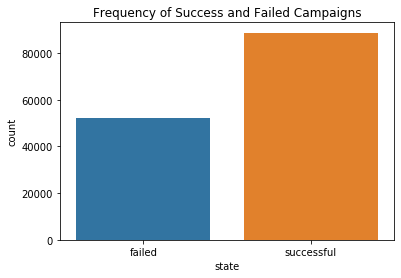

In [23]:
#create dummy count feature
df['count'] = 1

df_state = (df.groupby(['state'])
            .count()
            .reset_index())

sns.barplot(x = 'state', y = 'count', data = df_state)
plt.title('Frequency of Success and Failed Campaigns')

Since Kickstarter launched in 2009, there have been a total of 88758 successful campaigns and 52028 failed campaigns at a ratio of 1.71:1 success to fail campaign.

In [24]:
df_success = df[df.state == 'successful']
df_fail = df[df.state == 'failed']

#failed descriptive statistics
df_fail.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched,count
count,5.200900e+04,52009.000000,52009.000000,52009.000000,52009.000000,52009.0
mean,7.910922e+04,34.563749,34.563095,6.371186,2015.790248,1.0
std,1.594868e+06,12.686038,12.685937,3.309455,1.741267,0.0
min,1.000000e+00,1.000000,1.000000,1.000000,2009.000000,1.0
25%,2.452500e+03,30.000000,30.000000,4.000000,2015.000000,1.0
50%,7.000000e+03,30.000000,30.000000,6.000000,2016.000000,1.0
75%,2.234208e+04,40.000000,40.000000,9.000000,2017.000000,1.0
max,1.000000e+08,92.000000,92.000000,12.000000,2019.000000,1.0


Average failed campaigns have a set funding goal of 79.7k whereas the median is at 7k suggesting a left skewed distribution. Days to state change and length of campaign have the same statistics because campaigns fail only when the length of campaign is reached. From the 25% and 50% percentile, it's inferred that most campaigns are 30 days and this is the reason for mean slightly higher than 30 days at 34.6 days. Month launched column suggests an uniform distribution year round with 25%, 50% and 75% percentile spaced out quite equality, but more visualization must be done for a definitive conclusion. 

In [25]:
#successful descriptive statistics
df_success.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched,count
count,8.869000e+04,88690.000000,88690.000000,88690.000000,88690.000000,88690.0
mean,1.085175e+04,30.845247,30.843985,6.213947,2015.953016,1.0
std,7.817312e+04,10.667930,10.666661,3.270963,2.305294,0.0
min,1.000000e-02,1.000000,1.000000,1.000000,2009.000000,1.0
25%,1.114773e+03,28.000000,28.000000,3.000000,2014.000000,1.0
50%,3.600000e+03,30.000000,30.000000,6.000000,2016.000000,1.0
75%,1.000000e+04,32.000000,32.000000,9.000000,2018.000000,1.0
max,1.058978e+07,91.000000,91.000000,12.000000,2019.000000,1.0


Average successful campaign have a set funding goal of 10.5k and a median distribution of 3.6k suggesting a left skewed distibution. Compare this to that of the failed campaign, the distribution is sharper in that of a successful campaign. Mean of days to state change and that of length of campaign are similar suggesting that most successful campaigns end towards the deadline of the campaign. This suggestion aligns well with same 25%, 50%, and 75% percentile for both.

([<matplotlib.patches.Wedge at 0x28d828ff488>,
 [Text(-0.7941113297474437, 0.8996594888994096, 'US'),
  Text(0.28104819217193827, -1.1666241527059542, 'GB'),
  Text(0.807064629002062, -0.8880578160310084, 'CA'),
  Text(0.9772025923956258, -0.6964733257026207, 'AU'),
  Text(1.1556141384835215, -0.32335114494460715, 'Other')],
 [Text(-0.4632316090193421, 0.5248013685246555, '73.0'),
  Text(0.163944778766964, -0.6805307557451399, '11.5'),
  Text(0.47078770025120276, -0.5180337260180882, '4.5'),
  Text(0.5700348455641149, -0.406276106659862, '2.3'),
  Text(0.6741082474487209, -0.1886215012176875, '8.7')])

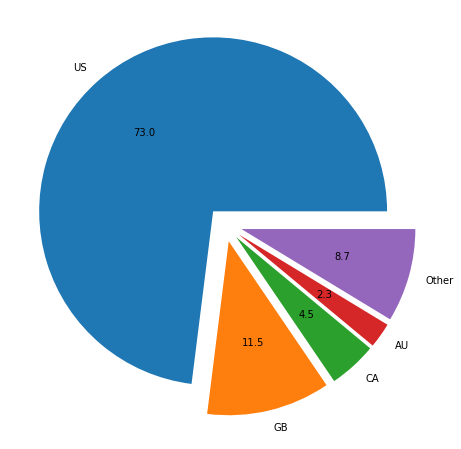

In [26]:
country_count = Counter()
for i in df.country:
    country_count[i] +=1

country = [[],[]]
for place, count in country_count.most_common(len(country_count)):
    country[0].append(place)
    country[1].append(count)
    
other_total = np.sum(country[1][4:])
country = [country[0][:4]+ ['Other'], country[1][:4] + [other_total]]
plt.figure(figsize = (8,8))
plt.pie(country[1], labels = country[0], explode = len(country[0])*[0.1], autopct = '%.1f')

The US attributes the majority of campaigns launched for english campaigns, accounting for almost 73% of total campaigns. Britain and Canada accounts for half of the remaining 25%.

<a id='Time'></a>

## 1a. Time Dependency for Successful Campaigns

(0, 60)

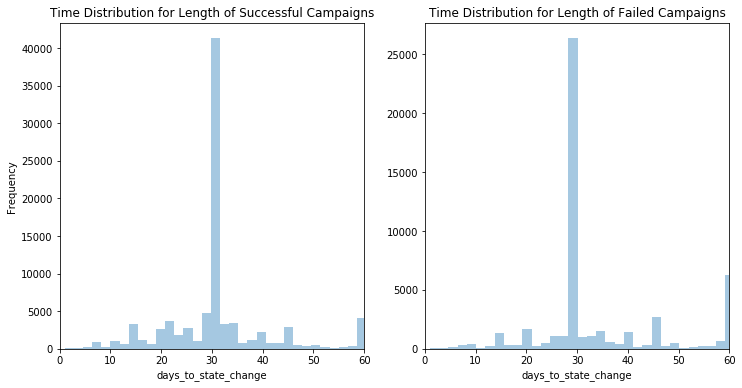

In [27]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

fig1 = sns.distplot(df_success['days_to_state_change'], kde = False, ax = axes[0])
fig1.set(xlabel='days_to_state_change', ylabel='Frequency', title ='Time Distribution for Length of Successful Campaigns')
fig1.set_xlim((0,60))

fig2 = sns.distplot(df_fail['days_to_state_change'], kde = False, ax = axes[1])
fig2.set(xlabel='days_to_state_change', title ='Time Distribution for Length of Failed Campaigns')
fig2.set_xlim((0,60))

In [28]:
#rate of 30 days for successful campaign
change30 = (df_success['days_to_state_change'] == 30)
rate30 = np.sum(change30)/len(change30)

print('Rate of 30 days for change of state', rate30)

Rate of 30 days for change of state 0.4250986582478295


Majority of successful campaigns takes 30 days for a change like inferred from descriptive statistics earlier. Failed campaign tends to have more 60 days campaign but overall majority of the campaigns launch ends within 30 days

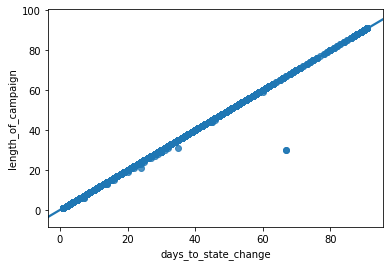

In [29]:
sns.regplot(x = 'days_to_state_change', y = 'length_of_campaign', data = df_success)

In [30]:
slope, y_intercept, r_value, p_value, stderr = scipy.stats.linregress(
    df_success['days_to_state_change'], df_success['length_of_campaign'])

print('Slope is', round(slope, 2))
print('y-intercept is', round(y_intercept, 2))
print('r-square value is', round(r_value**2, 3))
print('p-value is ', round(p_value, 2))

Slope is 1.0
y-intercept is 0.01
r-square value is 1.0
p-value is  0.0


Because both successful and failed campaign have similar days to state change and length of campaign column, the columns are obviously dependent and needs to be dropped. This also suggest that for most successful campaigns, state change from pending to successful happens on the last day of campaign.

In [31]:
df = df.drop(columns = ['days_to_state_change'])

Text(0.5, 1.0, 'Successfulness Frequency of by Year')

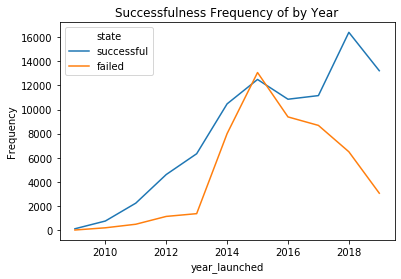

In [32]:
df_year = (df.groupby(['year_launched'])['state']
           .value_counts()
           .rename('Frequency')
           .reset_index().sort_values('year_launched'))

sns.lineplot(x = 'year_launched', y = 'Frequency', hue = 'state', data = df_year)
plt.title('Successfulness Frequency of by Year')

Exponential change in campaigns launched since Kickstarter launched in 2009. Interestingly for most of the duration of Kickstarter, rates of successful campaign dominaates that of failed campaign, however in 2015, failed rates overturned successful rates. The sharp decline in 2019 campaign may be a result of incomplete year and the remainder of 2019 campaign have not been accounted for. It also appears that failed campaigns have been declining drastically for the past 4 years. Inconsistently of the data between successful and failed rates may be a suggestion of incomplete online data for all the campaigns from the start of Kickstarter.

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Campaigns by Month and Year')

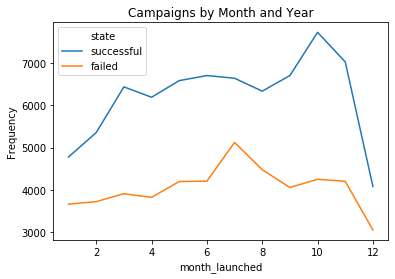

In [33]:
#adjust for incomplete year in 2009 and 2019
df_month = (df[df.year_launched > 2010][df.year_launched < 2019]
             .groupby(['month_launched'])['state']
             .value_counts()
             .rename('Frequency')
             .reset_index()
             .sort_values('month_launched'))

sns.lineplot(x = 'month_launched', y = 'Frequency', hue = 'state', data = df_month)
plt.title('Campaigns by Month and Year')

For the most part, it appears that campaigns are launched consistently throughout the year. January, Februrary, and December have obvious low rates of campaign launched with typically lower ratio between successful and failed campaigns. July appears to have a spike of 20% more failed campaigns than prior month with relatively consistently successful campaigns respectively. However, do note that this data include the first couple years of Kickstarter as a startup. This can impact the frequencies of month launched. To be more consistent with recent data, only 5 years are used in the following plot

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[Text(0.5, 1.0, 'Failed Campaigns by Month and Year')]

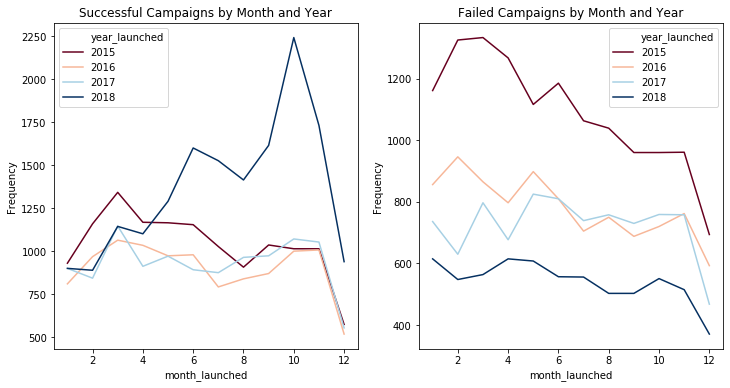

In [34]:
#most recent data
df_2015 = (df[df.year_launched > 2014][df.year_launched < 2019]
             .groupby(['month_launched', 'year_launched'])['state']
             .value_counts()
             .rename('Frequency')
             .reset_index()
             .sort_values('month_launched'))

fig, axes = plt.subplots(1,2, figsize = (12,6))
fig1 = sns.lineplot(x='month_launched', y='Frequency', hue = 'year_launched', 
             data=df_2015[df_2015.state == 'successful'], palette = 'RdBu',
            ax = axes[0])
fig1.set(title = 'Successful Campaigns by Month and Year', ylabel = 'Frequency')


fig2 = sns.lineplot(x='month_launched', y='Frequency', hue = 'year_launched', 
             data=df_2015[df_2015.state == 'failed'], palette = 'RdBu',
            ax = axes[1])
fig2.set(title = 'Failed Campaigns by Month and Year')

Similar December activity is shown for the past 4 years where launched campaigns experienced a sharp decline. From successful campaigns, launches are quite consistently thorughout the year except for 2018 where an increasing number of campaign throughout the year. Either this is an abnormality or campaign data are incomplete for prior years. Its consistent for the past 4 years that failed campaigns tends to launch as month increase

Text(0.5, 1.0, 'Ratio of Successful/Failed Campaign by Year and Month')

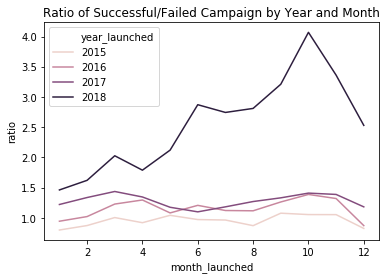

In [35]:
df_successful2015 = df_2015[df_2015.state == 'successful'].reset_index()
df_failed2015 = df_2015[df_2015.state == 'failed'].reset_index()

df_combined = df_successful2015.merge(right = df_failed2015, how = 'inner', 
                               left_on = ['month_launched', 'year_launched'], 
                               right_on = ['month_launched', 'year_launched'])

df_combined['ratio'] = df_combined.Frequency_x/df_combined.Frequency_y

sns.lineplot(x='month_launched', y = 'ratio', hue = 'year_launched', data = df_combined)
plt.title('Ratio of Successful/Failed Campaign by Year and Month')

As mentioned earlier, 2018 appears to be an outlier year in terms of campaign launched and it infers that the most ideal time to launch a successful campaign in October with a success to fail ratio of 4 to 1. For years prior to 2018, ideal time to launch is also in october/Nobember and March/April where success to fail ratio is 1.3

[Text(0.5, 1.0, 'Regression of Success/Fail Ratio and Month Launched')]

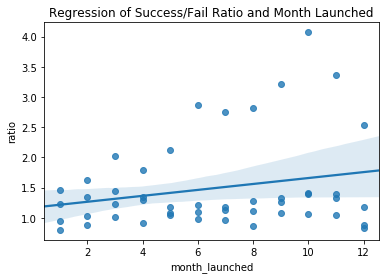

In [36]:
#regression line of success/fail ratio and month launched
fig = sns.regplot(x = 'month_launched', y = 'ratio', data = df_combined)
fig.set(title = 'Regression of Success/Fail Ratio and Month Launched')

In [37]:
y_intercept, slope, r_value, p_value, stderr = scipy.stats.linregress(df_combined['month_launched'], df_combined['ratio'])

print('Slope is', round(slope, 2))
print('y-intercept is', round(y_intercept, 2))
print('r-square value is', round(r_value**2, 3))
print('p-value is', round(p_value, 3))

Slope is 1.17
y-intercept is 0.05
r-square value is 0.053
p-value is 0.115


Unsurprisely shows no relationships between the two features since 2018 launched patterns differ from prior years

[Text(0.5, 1.0, 'Regression of Success/Fail Ratio and Month Launched without 2018')]

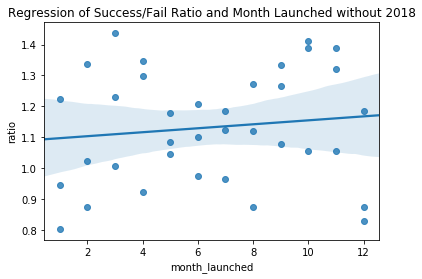

In [38]:
#regression line of success/fail ratio and month launched without 2018
fig = sns.regplot(x = 'month_launched', y = 'ratio', data = df_combined[df_combined['year_launched']<2018])
fig.set(title = 'Regression of Success/Fail Ratio and Month Launched without 2018')

In [39]:
y_intercept, slope, r_value, p_value, stderr = scipy.stats.linregress(df_combined[df_combined['year_launched']<2018]['month_launched'], 
                                                                      df_combined[df_combined['year_launched']<2018]['ratio'])

print('Slope is', round(slope, 2))
print('y-intercept is', round(y_intercept, 2))
print('r-square value is', round(r_value**2, 3))
print('p-value is', round(p_value, 3))

Slope is 1.09
y-intercept is 0.01
r-square value is 0.015
p-value is 0.471


Even without 2018 included, the regression shows almost a complete randomness. p-value of 0.476 reveals a statistically insignificant predictability of the model between the two features. There may not be seasonal affect on successful and failed campaigns.

<a id='Data_wrangling'></a>

## 2b. Funding Goal

(0, 75000)

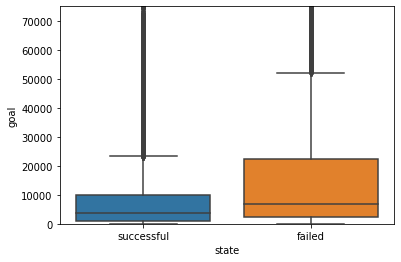

In [40]:
sns.boxplot(x = 'state', y = 'goal', data = df)
plt.ylim(0,75000)

In [41]:
failed_tile = np.percentile(df_fail['goal'], 90)
success_tile = np.percentile(df_success['goal'], 90)

print('95% of failed campaigned lies below $', failed_tile)
print('95% of successful campaigned lies below $', success_tile)

95% of failed campaigned lies below $ 60000.0
95% of successful campaigned lies below $ 21000.0


Due to high number of outliers, the funding goal of the box and whisker plot was limited to $75000. Form the diagram, failed campaign have a 75% coverage larger than that of successful campaigns by 25k, double that of the successful campaign. Furthermore, the 75% percentile of successful campaign is the same as 50% percentile of failed campaign. This suggests that the funding goal was overestimated or that the dominating categories of failed cmapaigns are just more costly.

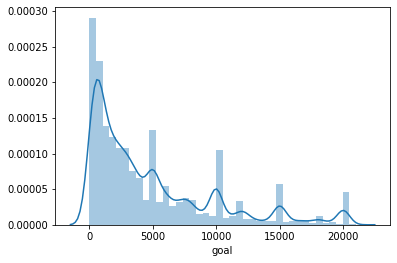

In [42]:
sns.distplot(df_success[df_success.goal < 21000]['goal'],bins = 40)

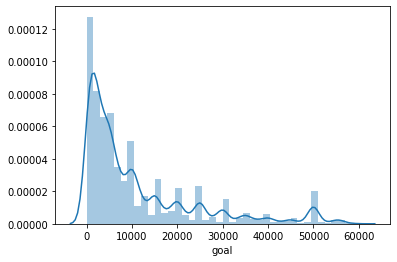

In [43]:
sns.distplot(df_fail[df_fail.goal < 60000]['goal'],bins = 40)

Both distributions experience an exponential decline for funding goals. Successful campaigns tamper out at around \\$6000 whereas failed campaigns tamper out at around \\$10000, showing most people campaigns for funding below those set amounts. Also spikes at certain intervals are human tendencies for round and nice numbers.

<a id='Data_wrangling'></a>

## 2c. Text

In [44]:
#count words from the title in failed and successful campaign
fail_count = Counter()
for title in df_fail.token_title:
    for word in title:
        fail_count[word]+=1

success_count = Counter()
for title in df_success.token_title:
    for word in title:
        success_count[word]+=1

[Text(0.5, 1.0, "Most Common Words in Successful Campaign's Title")]

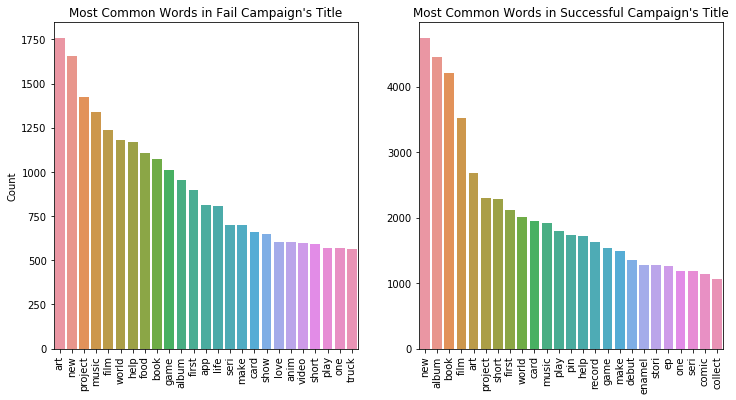

In [45]:
#determine the top 20 words from the title of the failed and successful campaign
fail_common = [[],[]]
for day, count in fail_count.most_common(25):
    fail_common[0].append(day)
    fail_common[1].append(count)
    
success_common = [[],[]]
for day, count in success_count.most_common(25):
    success_common[0].append(day)
    success_common[1].append(count)

fig, axes = plt.subplots(1,2, figsize = (12,6))
fig1 = sns.barplot(x = fail_common[0], y = fail_common[1], ax = axes[0])
fig1.set(ylabel = 'Count', title = "Most Common Words in Fail Campaign's Title")
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)


fig2 = sns.barplot(x = success_common[0], y = success_common[1], ax = axes[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90)
fig2.set(title = "Most Common Words in Successful Campaign's Title")

Failed and successful campaigns have many common words between one another. Words like "new", film, and "art" are in the top five most most common words. It's noteworthy that the counts of the top five words used in successful campaigns decrease more rapidly than those in the other top 20 most common words whereas in failed campaigns the top five words have more of a steady fall. Also successful to failed campaign ratio is 1.7:1. Usage of words in the top 20 in successful campaign are higher than that of failed campaign relative-wise and count-wise

In [46]:
#remove punctionuation from sentence
def no_punc(x):
    output =[]
    for word in x:
        if word.isalnum():
            output.append(word)
    return output

#remove punctions from title where stopwords were not removed
df['no_pun_tit'] = df['title'].apply(lambda x: no_punc(x))

In [47]:
#count the number of words in title for title without stopwords removal 
success_len1 = []
for title in df[df.state == 'successful'].no_pun_tit:
    success_len1.append(len(title))
    
fail_len1 = []
for title in df[df.state == 'failed'].no_pun_tit:
    fail_len1.append(len(title))

Text(0.5, 1.0, 'Distribution of Number of Words in Title')

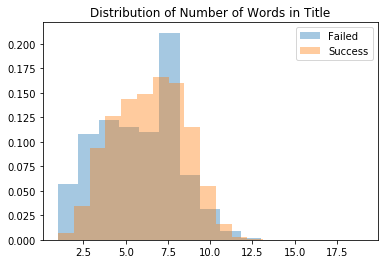

In [48]:
sns.distplot(fail_len1, bins = 15, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len1, bins = 15, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title("Distribution of Number of Words in Title")

In [49]:
avg_fail = np.mean(fail_len1)
avg_success = np.mean(success_len1)
print('Average number of words for failed campaign is', round(avg_fail, 2))
print('Average number of words for successful campaign is', round(avg_success,2))

Average number of words for failed campaign is 5.73
Average number of words for successful campaign is 6.29


Successful campaigns tend to have longer titles and that fact is exhibited by the average number of 6.1 compared to 5.61 words from the nonparametric distributions. We can conduct a null hypthesis to determine whether this is significant.

Null hypothesis: μ(# of words for failed campaigns) = μ(# of words for successful campaigns) <br>
Alternative hypthoesis: μ(# of words for failed campaigns) < μ(# of words for successful campaigns) <br>
alpha = .05

In [50]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len1 + fail_len1
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len1)])
    success = np.mean(perm[len(fail_len1):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.0


Based on p-value, the null hypthesis is rejected and the alternative hypthesis is accepted that the average number of words for successful campaigns larger than that for failed campaign.

Will this differ from important words? (important words are consider as those that are not stopwords)

In [51]:
#count the number of words in title for title with stopwords removal 
success_len2 = []
for title in df_success.token_title:
    success_len2.append(len(title))

fail_len2 = []
for title in df_fail.token_title:
    fail_len2.append(len(title))

Text(0.5, 1.0, 'Distribution of Number of "Important" Words in Title')

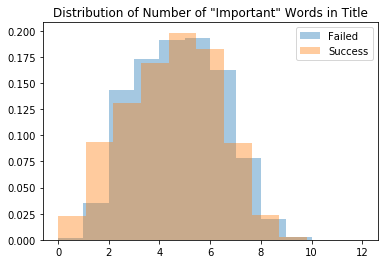

In [52]:
sns.distplot(fail_len2, bins = 11, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len2, bins = 11, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of "Important" Words in Title')

In [53]:
avg_fail = np.mean(fail_len2)
avg_success = np.mean(success_len2)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 4.28
Average number of important words for successful campaign is 4.62


It's articulated in average number that successful campaigns tends to have more important words than that of failed campaign, however it is less so obvious from the distributions. The significance of the mean difference is tested using a hypothesis testing.

Null hypothesis: μ(# of important words for failed campaigns) = μ(# of important words for successful campaigns) <br>
Alternative hypthoesis: μ(# of important words for failed campaigns) < μ(# of important words for successful campaigns) <br>
alpha = .05

In [54]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len2 + fail_len2
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len2)])
    success = np.mean(perm[len(fail_len2):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.0


It is showned statistically that based on the p-value, the null hypthosis is reject and the alternative hypothesis is accepted that mean number of important words for failed campaigns is smaller than that for successful campaigns.

Because we observed so many common words between individual words for both outcomes, it's more interesting to look at key pair words.

In [55]:
#count bigrams of title for successful and failed campaign
fail_bigram_count = Counter()
for title in df_fail.bigram_title:
    for bigram in list(title):
        fail_bigram_count[bigram]+=1

success_bigram_count = Counter()
for summary in df_success.bigram_title:
    for bigram in summary:
        success_bigram_count[bigram]+=1

[Text(0.5, 1.0, "Most Common Bigram in Successful Campaign's Title")]

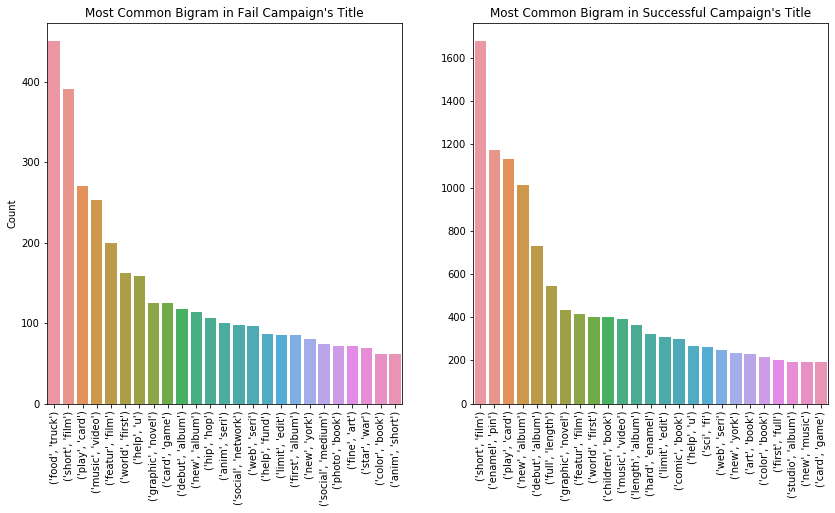

In [56]:
#find the top 20 bigram in title for successful and failed campaign
fail_bigram = [[],[]]

for words, count in fail_bigram_count.most_common(25):
    fail_bigram[0].append(str(words))
    fail_bigram[1].append(count)

success_bigram = [[],[]]

for words, count in success_bigram_count.most_common(25):
    success_bigram[0].append(str(words))
    success_bigram[1].append(count)
    
fig, axes = plt.subplots(1,2, figsize = (14,7))
fig1 = sns.barplot(x = fail_bigram[0], y = fail_bigram[1], ax = axes[0])
fig1.set(ylabel = 'Count', title = "Most Common Bigram in Fail Campaign's Title")
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)



fig2 = sns.barplot(x = success_bigram[0], y = success_bigram[1], ax = axes[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90)
fig2.set(title = "Most Common Bigram in Successful Campaign's Title")

Bigram provides a better insight into the successfullness of campaigns. For example "food truck" is the leading pair of words that indicate failed campaigns however, top 20 pair of words for successful campaigns do not have "food truck" indicating a strong inherit fail rate for food trucks. This is unlike "short film" where both campaigns have high rate of the word pair, although, successful campaign has a higher count and relative proportion.

In [57]:
#count words from the summary in failed and successful campaign
fail_count = Counter()
for summary in df_fail.token_summary:
    for word in summary:
        fail_count[word]+=1

success_count = Counter()
for summary in df_success.token_summary:
    for word in summary:
        success_count[word]+=1

[Text(0.5, 1.0, "Most Common Words in Successful Campaign's Summary")]

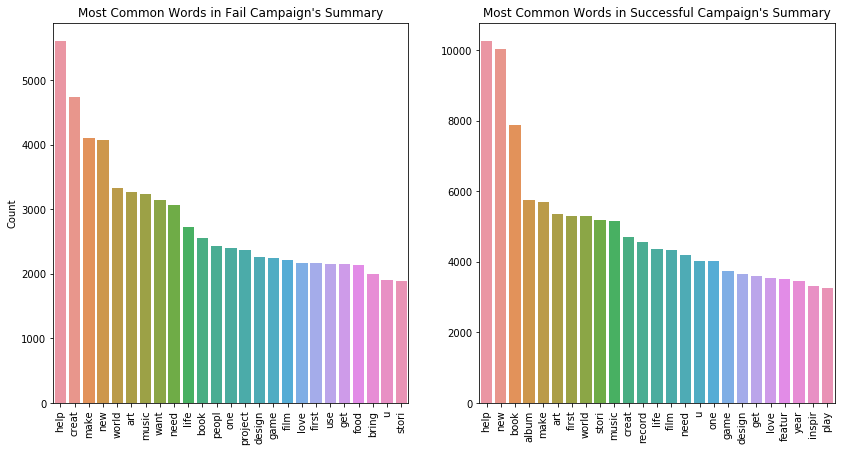

In [58]:
#determine the top 20 words from the summary of the failed and successful campaign
fail_common = [[],[]]
for day, count in fail_count.most_common(25):
    fail_common[0].append(day)
    fail_common[1].append(count)
    

success_common = [[],[]]
for day, count in success_count.most_common(25):
    success_common[0].append(day)
    success_common[1].append(count)

fig, axes = plt.subplots(1,2, figsize = (14,7))
fig1 = sns.barplot(x = fail_common[0], y = fail_common[1], ax = axes[0])
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)
fig1.set(ylabel = 'Count', title = "Most Common Words in Fail Campaign's Summary")


fig2 = sns.barplot(x = success_common[0], y = success_common[1], ax = axes[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90)
fig2.set(title = "Most Common Words in Successful Campaign's Summary")

In [59]:
#remove punctualation from summary without stopwords removal
df['no_pun_sum'] = df['summary'].apply(lambda x: no_punc(x))

#determine the number of words in summary without stopwords removal
success_len1 = []
for summary in df[df.state == 'successful'].no_pun_sum:
    success_len1.append(len(summary))
    
fail_len1 = []
for summary in df[df.state == 'failed'].no_pun_sum:
    fail_len1.append(len(summary))

Text(0.5, 1.0, 'Distribution of Number of Words in Summary')

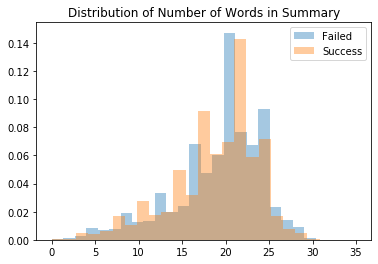

In [60]:
sns.distplot(fail_len1,bins = 25, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len1, bins = 25, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of Words in Summary')

In [61]:
avg_fail = np.mean(fail_len1)
avg_success = np.mean(success_len1)
print('Average number of words for failed campaign is', round(avg_fail, 2))
print('Average number of words for successful campaign is', round(avg_success,2))

Average number of words for failed campaign is 19.25
Average number of words for successful campaign is 18.77


Both average numbers for failed and successful campaigns are similar with less than 3% difference. An hypthesis testing is used to determine the significance of the difference.

Null hypothesis: μ(# of words for failed campaigns) = μ(# of words for successful campaigns) <br>
Alternative hypthoesis: μ(# of words for failed campaigns) < μ(# of words for successful campaigns) <br>
alpha = .05

In [62]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len1 + fail_len1
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len1)])
    success = np.mean(perm[len(fail_len1):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.07107371054520643


Based on the p-value of 0.07 compared to alpha of 0.05, we failed to reject the null hypothesis that the number of words for failed campaign in the summary may be equal to that of successful campaign

In [63]:
#determine the number of words in summary with stopwords removal
success_len2 = []
for summary in df_success.token_summary:
    success_len2.append(len(summary))

fail_len2 = []
for summary in df_fail.token_summary:
    fail_len2.append(len(summary))

Text(0.5, 1.0, 'Distribution of Number of "Important" Words in Summary')

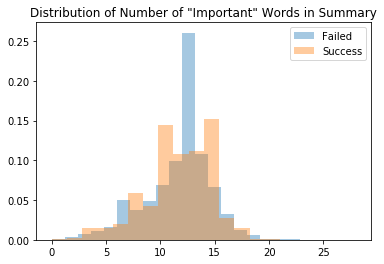

In [64]:
sns.distplot(fail_len2, bins = 20, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len2, bins = 20, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of "Important" Words in Summary')

In [65]:
avg_fail = np.mean(fail_len2)
avg_success = np.mean(success_len2)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 11.61
Average number of important words for successful campaign is 11.58


Failed and successful campaigns have similar number of "important" words and isn't useful for differentiation of outcome

In [66]:
#count bigrams of summary for successful and failed campaign
fail_bigram_count = Counter()
for summary in df_fail.bigram_summary:
    for bigram in list(summary):
        fail_bigram_count[bigram]+=1

success_bigram_count = Counter()
for summary in df_success.bigram_summary:
    for bigram in summary:
        success_bigram_count[bigram]+=1

[Text(0.5, 1.0, "Most Common Bigram in Successful Campaign's Summary")]

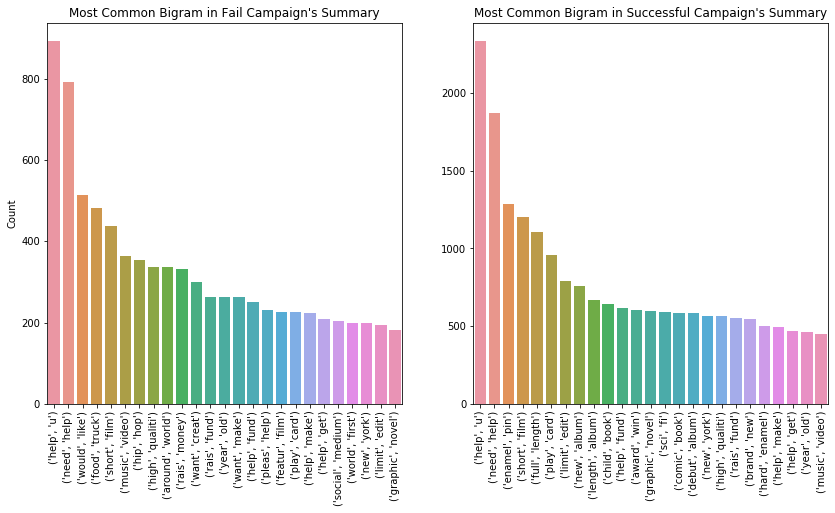

In [67]:
fail_bigram = [[],[]]
for words, count in fail_bigram_count.most_common(25):
    fail_bigram[0].append(str(words))
    fail_bigram[1].append(count)

    
success_bigram = [[],[]]
for words, count in success_bigram_count.most_common(25):
    success_bigram[0].append(str(words))
    success_bigram[1].append(count)

fig, axes = plt.subplots(1,2, figsize = (14,7))
fig1 = sns.barplot(x = fail_bigram[0], y = fail_bigram[1], ax =axes[0])
fig1.set(ylabel = 'Count', title = "Most Common Bigram in Fail Campaign's Summary")
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)


fig2 = sns.barplot(x = success_bigram[0], y = success_bigram[1], ax = axes[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90)
fig2.set(title = "Most Common Bigram in Successful Campaign's Summary")

"Help u" and "need help" are two common pairs of words used all campaigns. "Food Truck" is still a strong indicator for failed campaign

<a id='learn'></a>

# Machine Learning

In [68]:
#count the number of words in title for title with stopwords removal 
df['length'] = df['token_title'].apply(lambda x: len(x))

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140699 entries, 0 to 207620
Data columns (total 17 columns):
summary               140699 non-null object
country               140699 non-null object
goal                  140699 non-null float64
title                 140699 non-null object
state                 140699 non-null object
length_of_campaign    140699 non-null int64
month_launched        140699 non-null int64
year_launched         140699 non-null int64
language              140699 non-null object
token_title           140699 non-null object
token_summary         140699 non-null object
bigram_title          140699 non-null object
bigram_summary        140699 non-null object
count                 140699 non-null int64
no_pun_tit            140699 non-null object
no_pun_sum            140699 non-null object
length                140699 non-null int64
dtypes: float64(1), int64(5), object(11)
memory usage: 24.3+ MB


<a id='logistic'></a>

## Logistics Regression

In [70]:
#combined the previously tokenized title and summary for sklearn bag of words and Tfidf
#text has already been preprocessed previously by removing non-english campaign, lowercase, stopwords, stemming/lemmatizing
df['token_title'] = df['token_title'].apply(lambda x: ' '.join(x))
df['token_summary'] = df['token_summary'].apply(lambda x: ' '.join(x))

#merge the title and summary to one text
df['title_summary'] = df['token_title'] + ' ' + df['token_summary']

In [71]:
#select features
X = df[['goal', 'length_of_campaign', 'length', 'country', 
               'month_launched', 'year_launched', 'token_title']]

#select target
y = df[['state']]

#split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [72]:
#numeric features
get_numeric = ['goal', 'length_of_campaign', 'length']

#categorical features
get_categorical = ['country', 'month_launched', 'year_launched']

#text feature
get_text = 'token_title'

#numeric pipeline
num_pipe = Pipeline([('scale', StandardScaler())])

#categorical pipeline
cat_pipe = Pipeline([('onehot', OneHotEncoder())])

#text pipeline for CountVectorizer
text_pipe1 = Pipeline([('Count', CountVectorizer(ngram_range = (1,2)))])

#text pipeline for Tfidf
text_pipe2 = Pipeline([('Count', TfidfVectorizer(ngram_range = (1,2)))])

#preprocesscor for Bag of words
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', num_pipe, get_numeric),
        ('cat', cat_pipe, get_categorical), 
        ('text', text_pipe1, get_text)])

#preprocessor for Tf-idf
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_pipe, get_numeric),
        ('cat', cat_pipe, get_categorical), 
        ('text', text_pipe2, get_text)])

In [73]:
#create Bag of words pipeline with logistic regression
pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('classifier', LogisticRegression())])

#Randomized cross validation with fine tuning C
param_grid = {'classifier__C': np.logspace(-3, 0, num = 50)}
clf = RandomizedSearchCV(pipe1, param_grid, cv = 3, verbose = 15, n_iter = 10, 
                           scoring = 'accuracy', n_jobs = 3, random_state = 12)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   29.0s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   29.2s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   29.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   36.4s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   36.7s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   37.2s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   50.1s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   50.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   51.0s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  1.0min
[Parallel(

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                

In [74]:
print('Best C:', clf.best_params_)

Best C: {'classifier__C': 0.655128556859551}


In [75]:
print('Best Score:', clf.best_score_)

Best Score: 0.7344414929059426


In [76]:
print('Performance of Logistic Regression on test:', clf.score(X_test, y_test))

Performance of Logistic Regression on test: 0.7418265813788202


The score from the cross validation aligns well with the preformance of the test data set with 1.5% difference. The small difference is an indication of low variance.

In [77]:
#confusion matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 5676,  4773],
       [ 2492, 15199]], dtype=int64)

From the confusion matrix, almost have of failed campaign was predicted as false positive. It may be difficult to predict true failed campaign compared to true successful campaign using bag of words

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      failed       0.69      0.54      0.61     10449
  successful       0.76      0.86      0.81     17691

    accuracy                           0.74     28140
   macro avg       0.73      0.70      0.71     28140
weighted avg       0.74      0.74      0.73     28140



In [79]:
#pipeline for logistic regression of Tfidf
pipe2 = Pipeline([('preprocessor', preprocessor2),
                 ('classifier', LogisticRegression())])

#Randomized cross validation with fine tuning C
param_grid = {'classifier__C': np.logspace(-3, 0, num = 50)}
clf2 = RandomizedSearchCV(pipe2, param_grid, cv = 3, verbose = 15, n_iter = 10, 
                           scoring = 'accuracy', n_jobs = 3, random_state = 12)

clf2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   28.8s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   29.2s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   29.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   34.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   35.3s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   35.7s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   48.3s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   49.0s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   49.6s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   58.9s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   59.8s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  1.0min
[Parallel(

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                

In [80]:
print('Best C:', clf2.best_params_)

Best C: {'classifier__C': 0.868511373751352}


In [81]:
print('Best Score:', clf2.best_score_)

Best Score: 0.7311365594932435


In [82]:
print('Performance of Logistic Regression on test:', clf2.score(X_test, y_test))

Performance of Logistic Regression on test: 0.7344705046197584


The score from the cross validation aligns well with the preformance of the test data set with 0.9% difference. The small difference is an indication of low variance

In [83]:
y_pred = clf2.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 5532,  4917],
       [ 2555, 15136]], dtype=int64)

Again the confusion matrix suggest it may be difficult to predict true failed campaign compared to true successful campaign

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      failed       0.68      0.53      0.60     10449
  successful       0.75      0.86      0.80     17691

    accuracy                           0.73     28140
   macro avg       0.72      0.69      0.70     28140
weighted avg       0.73      0.73      0.73     28140



<a id='deep'></a>

## Deep Learning

In [85]:
df.head()

,summary,country,goal,title,state,length_of_campaign,month_launched,year_launched,language,token_title,token_summary,bigram_title,bigram_summary,count,no_pun_tit,no_pun_sum,length,title_summary
0,"[funding, the, mixing, mastering, and, promoti...",US,5000.00000,"[john, chuck, and, the, class, debut, ep]",successful,30,3,2016,en,john chuck class debut ep,fund mix master promot debut ep indi hip hop d...,"[(john, chuck), (chuck, class), (class, debut)...","[(fund, mix), (mix, master), (master, promot),...",1,"[john, chuck, and, the, class, debut, ep]","[funding, the, mixing, mastering, and, promoti...",5,john chuck class debut ep fund mix master prom...
1,"[we, follow, the, challenges, and, achievement...",US,24042.00000,"[girls, of, summer, big, diamond, dreams]",successful,26,6,2017,en,girl summer big diamond dream,follow challeng achiev girl woman play basebal...,"[(girl, summer), (summer, big), (big, diamond)...","[(follow, challeng), (challeng, achiev), (achi...",1,"[girls, of, summer, big, diamond, dreams]","[we, follow, the, challenges, and, achievement...",5,girl summer big diamond dream follow challeng ...
3,"[major, key, alert, future, heroes, is, a, den...",US,500.00000,"[future, heroes, sxsw, is, calling]",successful,19,2,2016,en,futur hero sxsw call,major key alert futur hero denver rap duo go s...,"[(futur, hero), (hero, sxsw), (sxsw, call)]","[(major, key), (key, alert), (alert, futur), (...",1,"[future, heroes, sxsw, is, calling]","[major, key, alert, future, heroes, is, a, den...",4,futur hero sxsw call major key alert futur her...
4,"[we, 're, traveling, to, rhode, island, to, fi...",US,2500.00000,"[pelagic, shark, diving, shoot]",successful,30,6,2016,en,pelag shark dive shoot,travel rhode island film mako blue shark highl...,"[(pelag, shark), (shark, dive), (dive, shoot)]","[(travel, rhode), (rhode, island), (island, fi...",1,"[pelagic, shark, diving, shoot]","[we, traveling, to, rhode, island, to, film, m...",4,pelag shark dive shoot travel rhode island fil...
5,"[in, struggle, town, the, streets, are, protec...",AU,1019.09097,"[gorilla, my, dreams, mime, of, my, life]",successful,28,10,2017,en,gorilla dream mime life,struggl town street protect knockaround guy ta...,"[(gorilla, dream), (dream, mime), (mime, life)]","[(struggl, town), (town, street), (street, pro...",1,"[gorilla, my, dreams, mime, of, my, life]","[in, struggle, town, the, streets, are, protec...",4,gorilla dream mime life struggl town street pr...


In [86]:
#remove stopwords
df['title'] = df['title'].apply(lambda x: important_words(x))
df['summary'] = df['summary'].apply(lambda x: important_words(x))

#convert title and summary back to string
df['title'] = df['title'].apply(lambda x: ' '.join(x))
df['summary'] = df['summary'].apply(lambda x: ' '.join(x))

In [87]:
#text to sequence for title with max # words of 50000
tokenizer_tit = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_tit.fit_on_texts(df['title'])
X_title = tokenizer_tit.texts_to_sequences(df['title'])

In [88]:
#measure longest text
def longest(text):
    maximum = 0
    for i in text:
        maximum = max(maximum,len(i))
    return maximum

#find longest title
max_title = longest(X_title)

#pad with longest title
X_title = pad_sequences(X_title, maxlen=max_title)

In [89]:
#text to sequence for summary with max # words of 50000
tokenizer_sum = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_sum.fit_on_texts(df['summary'])
X_summary = tokenizer_sum.texts_to_sequences(df['summary'])

#find longest summary
max_summary = longest(X_summary)

#pad with longest summary
X_summary = pad_sequences(X_summary, maxlen=max_summary)

In [90]:
#scale numerical features
scale = StandardScaler()
temp1 = scale.fit_transform(df[get_numeric])

#encode categorical features
onehot = OneHotEncoder(sparse = False)
temp2 = onehot.fit_transform(df[get_categorical])

#concatenate numericaland categorical features
X = np.concatenate((temp1,temp2), axis = 1)

#set target variable
y = df['state'].apply(lambda x: 1 if x == 'successful' else 0)
y = np.array(y).reshape((-1,1))

In [91]:
#split the data to train and test data
X_tit_train, X_tit_test, X_sum_train, X_sum_test, X_train, X_test, y_train, y_test = (
    train_test_split(X_title, X_summary, X, y, test_size = 0.2, random_state = 10))

In [92]:
#input shape
seq_length1 = X_title.shape[1]
seq_length2 = X_summary.shape[1]
meta_length = X.shape[1]

In [95]:
#create nlp input
nlp_input1 = Input(shape=(seq_length1,), name='nlp_input1')
nlp_input2 = Input(shape = (seq_length2,), name = 'nlp_input2')

#create categorical and numerical input
meta_input = Input(shape=(meta_length,), name='meta_input')

#embedding for title with word vector size of 50 
emb1 = Embedding(input_dim = 50000, output_dim=100, input_length=seq_length1)(nlp_input1)
#LSTM network with 64 memory unit
nlp_out1 = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(emb1)

#embdding for title with word vector size of 50
emb2 = Embedding(input_dim = 50000, output_dim=100, input_length=seq_length2)(nlp_input2)
#LSTM network with 64 memory unit
nlp_out2 = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(emb2)

#meta input and layer1
meta_layer1 = Dense(256, input_shape = (meta_length,))(meta_input)
meta_layer1 = Activation('relu')(meta_layer1)

#layer2
meta_layer2 = Dense(128)(meta_layer1)
meta_layer2 = Dropout(0.3)(meta_layer2)
meta_layer2 = Activation('relu')(meta_layer2)

#layer3
meta_layer3 = Dense(64, kernel_regularizer=regularizers.l2(0.02))(meta_layer2)
meta_layer3 = BatchNormalization()(meta_layer3)
meta_out = Activation('relu')(meta_layer3)


#merge layers
merged_X = Concatenate(axis = 1)([nlp_out1, nlp_out2, meta_out])

#fully connected layers
FC1 = Dense(64, activation='relu')(merged_X)
FC2 = Dense(64, activation='relu')(FC1)
FC3 = Dense(1, activation='sigmoid')(FC2)
model = Model(inputs=[nlp_input1, nlp_input2, meta_input], outputs=[FC3])

#use binary cross entropy because we have a binary classification with Adam optimizer at learning rate of 0.00003
model.compile(optimizer =  Adam(lr=0.00004), loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
                         
hist = model.fit([X_tit_train, X_sum_train, X_train], y_train, 
               validation_split = 0.3, batch_size = 256, epochs = 40, verbose = 2, callbacks=callbacks)

Train on 78791 samples, validate on 33768 samples
Epoch 1/40
 - 120s - loss: 2.1696 - acc: 0.6273 - val_loss: 2.0033 - val_acc: 0.6510
Epoch 2/40
 - 114s - loss: 1.8631 - acc: 0.6531 - val_loss: 1.7277 - val_acc: 0.6647
Epoch 3/40
 - 119s - loss: 1.6054 - acc: 0.6764 - val_loss: 1.4798 - val_acc: 0.7021
Epoch 4/40
 - 120s - loss: 1.3700 - acc: 0.7168 - val_loss: 1.2726 - val_acc: 0.7320
Epoch 5/40
 - 145s - loss: 1.1698 - acc: 0.7517 - val_loss: 1.1104 - val_acc: 0.7442
Epoch 6/40
 - 124s - loss: 1.0081 - acc: 0.7728 - val_loss: 0.9853 - val_acc: 0.7480
Epoch 7/40
 - 126s - loss: 0.8733 - acc: 0.7895 - val_loss: 0.8878 - val_acc: 0.7504
Epoch 8/40
 - 133s - loss: 0.7615 - acc: 0.8045 - val_loss: 0.8119 - val_acc: 0.7518
Epoch 9/40
 - 114s - loss: 0.6666 - acc: 0.8196 - val_loss: 0.7545 - val_acc: 0.7510
Epoch 10/40
 - 129s - loss: 0.5858 - acc: 0.8336 - val_loss: 0.7144 - val_acc: 0.7465
Epoch 11/40
 - 152s - loss: 0.5203 - acc: 0.8436 - val_loss: 0.6865 - val_acc: 0.7492
Epoch 12/40
 

In [96]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
meta_input (InputLayer)         (None, 48)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 256)          12544       meta_input[0][0]                 
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 256)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 128)          32896       activation_7[0][0]               
__________________________________________________________________________________________________
dropout_3 

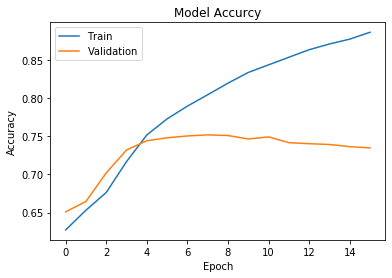

In [97]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accurcy')
plt.legend(['Train', 'Validation'])

In [99]:
y_pred = model.predict([X_tit_test, X_sum_test, X_test])
y_pred = [round(i[0]) for i in y_pred]

In [100]:
print('Accuracy of test data is', accuracy_score(y_test, y_pred))

Accuracy of test data is 0.7375266524520255


In [101]:
print(confusion_matrix(y_test, y_pred))

[[ 6424  4025]
 [ 3361 14330]]


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63     10449
           1       0.78      0.81      0.80     17691

    accuracy                           0.74     28140
   macro avg       0.72      0.71      0.72     28140
weighted avg       0.73      0.74      0.74     28140



Comparing the accuracy of the test data set of the nueral network model and that of the logistics regression, not much improvement was seen considering the time spend on training. The graph above, it's clear that the accuracy of the validation have plateau around 6 or 7 epoch at 75%. For better performance, we may want to monitor the val_acc instead of val_loss.

<a id='future'></a>

# Future Work

-investigate usefulness of both title and summary for machine learning. If the use of one is sufficient, one can be ommitted to speed up training

-use a bidirectional lstm instead of unidirection lstm on the nlp part of the deep learning to possibly improve accuracy

-increase word vector size in embedding

-change earlystop to monitor validation accuracy instead of validation loss for possible 2% improvement in accuracy

-fine tuning hyperparameters of the deep neural network for better accuracy like alpha, optimizer, and batch size

-decrease learning rate to better capture accuracy plateau